In [9]:
%pip install transformers torch datasets evaluate accelerate timm kagglehub pandas seaborn evaluate

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
df = pd.read_csv("datasets/ColBERT_Humor_Detection.csv")
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


Utilisation de la colonne texte : 'text'



/tmp/ipykernel_33223/4137132412.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette='pastel')


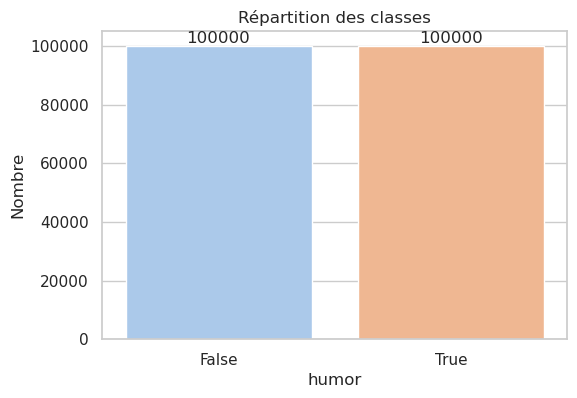

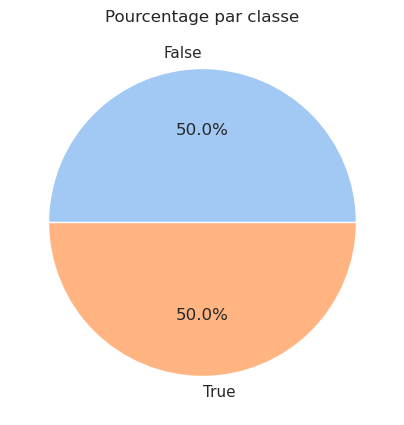

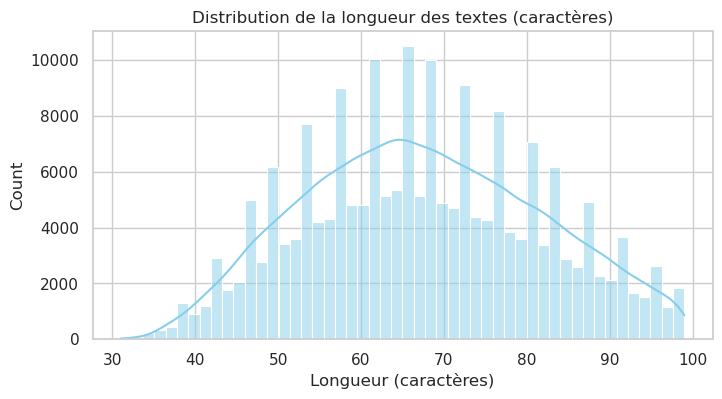

/tmp/ipykernel_33223/4137132412.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='humor', y='text_length_chars', data=df, palette='pastel')


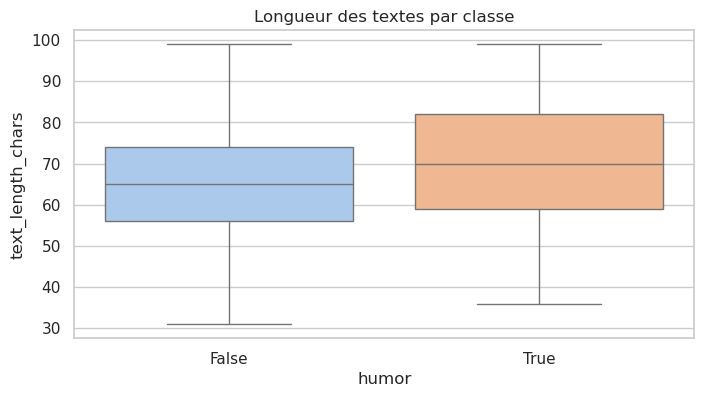


--- Exemples pour la classe False ---


,text
151382,Six quirky reasons to fall in love with portland
160200,Hillary clinton's super pac has raised more mo...
39931,Study: us cities have worse inequality than me...
153307,Rza loves...clarks wallabies? (and more findin...
185999,Trevor noah highlights an awful consequence of...



--- Exemples pour la classe True ---


,text
151508,"When you hold me, i'd prefer it not be account..."
160519,What did the baker name her dog? pido.
39516,I masturbated so good last night that i woke u...
153511,How do you know google is a male? because it k...
185964,Donald trump is so narcissistic... when he loo...



Top 20 tokens pour la classe False:
the(33063), to(29740), s(22806), a(18121), of(17753), in(17723), and(13568), for(13531), is(9877), on(9773), trump(8007), with(7568), you(7405), your(5554), photos(5165), at(5021), t(4976), how(4959), new(4934), it(4615)

Top 20 tokens pour la classe True:
a(59810), the(50149), i(34461), you(32192), what(28196), to(24525), s(20678), do(18373), it(17906), in(15865), of(15298), is(15088), and(14590), my(14100), t(13420), why(11916), did(9975), they(8899), was(8859), he(8756)


In [11]:
# Visualisations détaillées du jeu de données
# - Répartition par classe (barplot + camembert)
# - Distribution de la longueur des textes
# - Exemples d'instances par classe
# - Top tokens simples par classe

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from IPython.display import display

sns.set(style="whitegrid")

# Détection de la colonne texte (essayer plusieurs noms usuels)
text_candidates = ['text', 'sentence', 'content', 'comment', 'post', 'headline', 'joke', 'body']
text_col = next((c for c in text_candidates if c in df.columns), None)
if text_col is None:
    obj_cols = [c for c in df.columns if df[c].dtype == 'object' and c != 'humor']
    text_col = obj_cols[0] if obj_cols else None

if text_col is None:
    print("Impossible de trouver automatiquement une colonne texte. Colonnes disponibles :", df.columns.tolist())
else:
    print(f"Utilisation de la colonne texte : '{text_col}'\n")

    # Répartition des classes
    counts = df['humor'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette='pastel')
    plt.xlabel('humor')
    plt.ylabel('Nombre')
    plt.title('Répartition des classes')
    for i, v in enumerate(counts.values):
        plt.text(i, v + max(counts.values) * 0.01, str(v), ha='center')
    plt.show()

    # Camembert (pourcentages)
    plt.figure(figsize=(5,5))
    plt.pie(counts.values, labels=[str(i) for i in counts.index.astype(str)], autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title('Pourcentage par classe')
    plt.show()

    # Longueur des textes (en caractères)
    df['_text_str'] = df[text_col].astype(str)
    df['text_length_chars'] = df['_text_str'].apply(len)
    plt.figure(figsize=(8,4))
    sns.histplot(df['text_length_chars'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution de la longueur des textes (caractères)')
    plt.xlabel('Longueur (caractères)')
    plt.show()

    # Boxplot par classe (longueur)
    plt.figure(figsize=(8,4))
    sns.boxplot(x='humor', y='text_length_chars', data=df, palette='pastel')
    plt.title('Longueur des textes par classe')
    plt.show()

    # Afficher quelques exemples pour chaque classe
    for cls in sorted(df['humor'].unique()):
        print(f"\n--- Exemples pour la classe {cls} ---")
        sample = df[df['humor'] == cls]['_text_str'].dropna()
        if sample.empty:
            print("Aucun exemple trouvé pour cette classe.")
        else:
            display(sample.sample(min(5, len(sample)), random_state=42).to_frame(name=text_col))

    # Top tokens par classe (tokenisation simple)
    def tokenize(text):
        return re.findall(r"\w+", text.lower())

    topn = 20
    for cls in sorted(df['humor'].unique()):
        texts = df[df['humor'] == cls]['_text_str'].dropna().str.cat(sep=' ')
        tokens = tokenize(texts)
        common = Counter(tokens).most_common(topn)
        print(f"\nTop {topn} tokens pour la classe {cls}:")
        print(', '.join([f"{t[0]}({t[1]})" for t in common]))

    # Nettoyage temporaire
    try:
        df.drop(columns=['_text_str'], inplace=True)
    except Exception:
        pass


In [ ]:
# Entrainé un modèle sur une base d'un transformer (BERT, RoBERTa, DistilBERT, etc.) pour la classification binaire (humour vs non-humour)
# - Préparation des données (tokenization, encodage)
# - Entrainement avec un optimiseur adapté (AdamW, etc.)
# - Evaluation sur un jeu de test (accuracy, F1-score, etc.)
# - Sauvegarde du modèle entrainé
# - (Optionnel) Fine-tuning avec hyperparamètres optimaux (learning rate, batch size, epochs, etc.)

df = pd.read_csv("data/processed/colbert_humor.csv")  # déja tokenizé/source CSV

from datasets import Dataset
import evaluate

# Si vous aviez besoin d'une métrique, utilisez evaluate (load_metric a été retiré de 'datasets')
# Exemple : metric = evaluate.load("accuracy")

dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
print(dataset)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
# Remove only columns that are actually present (avoid ValueError). Do not remove 'text' before tokenization.
cols_to_try = ['__index_level_0__']
cols_present = [c for c in cols_to_try if c in encoded_dataset['train'].column_names]
if cols_present:
    encoded_dataset = encoded_dataset.remove_columns(cols_present)

# Ensure the label column is named 'labels' because Trainer expects 'labels' by default
if 'labels' not in encoded_dataset['train'].column_names:
    label_candidate = 'humor' if 'humor' in encoded_dataset['train'].column_names else ('label' if 'label' in encoded_dataset['train'].column_names else None)
    if label_candidate is None:
        raise ValueError(f"No label column found. Available columns: {encoded_dataset['train'].column_names}")
    # When using batched=True the function receives lists; convert labels to int to force CrossEntropyLoss (not BCEWithLogits)
    def _add_labels(batch):
        labels = batch[label_candidate]
        batch['labels'] = [int(l) for l in labels]
        return batch
    encoded_dataset = encoded_dataset.map(_add_labels, batched=True)
    # Optionally remove the old label column
    if label_candidate in encoded_dataset['train'].column_names:
        encoded_dataset = encoded_dataset.remove_columns([label_candidate])

# Ensure labels have integer dtype in the dataset features (best-effort)
try:
    from datasets import Value
    encoded_dataset = encoded_dataset.cast_column('labels', Value('int64'))
except Exception:
    # cast_column may fail depending on datasets version; we've already converted to int above
    pass

encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    fp16=True,
)

def compute_metrics(p):
    # p.predictions can be logits shape (batch, num_labels). Use argmax for multiclass/ single-label classification.
    import numpy as np
    # Normalize predictions and labels to 1-D numpy arrays
    preds = p.predictions
    labels = p.label_ids
    # If logits/probs have shape (N, num_labels) -> take argmax
    if hasattr(preds, 'ndim') and preds.ndim > 1:
        preds = np.argmax(preds, axis=-1)
    else:
        # binary logits/probs -> threshold at 0.5
        preds = (preds > 0.5).astype(int)
    preds = np.asarray(preds).flatten()
    labels = np.asarray(labels).flatten()
    acc = (preds == labels).mean()
    # Return plain Python float (avoids numpy scalar types that can trigger warnings in gather)
    return {'accuracy': float(acc)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
)



DatasetDict({
    train: Dataset({
        features: ['text', 'humor', 'label', 'text_clean'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['text', 'humor', 'label', 'text_clean'],
        num_rows: 40000
    })
})


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [15]:
trainer.train()
trainer.evaluate()
model.save_pretrained("./humor_detection_model")

ValueError: Caught ValueError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/parallel/parallel_apply.py", line 99, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.13/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 942, in forward
    loss = loss_fct(logits, labels)
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/modules/loss.py", line 828, in forward
    return F.binary_cross_entropy_with_logits(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        input,
        ^^^^^^
    ...<3 lines>...
        reduction=self.reduction,
        ^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/conda/lib/python3.13/site-packages/torch/nn/functional.py", line 3593, in binary_cross_entropy_with_logits
    raise ValueError(
        f"Target size ({target.size()}) must be the same as input size ({input.size()})"
    )
ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 2]))
